### Make a heavy Hex Code in Stim ###

In [ ]:
import stim
import pymatching

import numpy as np

from heavy_hex_code import HeavyHexCode

In [14]:
# creating a surface code to see how it is structured in stim -- what is the convention
# rotated_memory_z surface code is a memory experiment, in which the qubit is in the |0> state
# rotated_memory_x surface code is a memory experiment, in which the qubit is in the |+> state
surface_code_circuit=stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.02,
    before_measure_flip_probability=0.03,
    before_round_data_depolarization=0.04,
)

In [15]:
print(repr(surface_code_circuit))

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19
    X_ERROR(0.02) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.02) 2 9 11 13 14 16 18 25
    TICK
    DEPOLARIZE1(0.04) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    DEPOLARIZE1(0.01) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 

In [22]:
print(surface_code_circuit.count_determined_measurements(), surface_code_circuit.num_detectors, surface_code_circuit.num_observables)

17 16 1


In [23]:
sampler=surface_code_circuit.compile_detector_sampler()
detection_events, observable_flips=sampler.sample(100, separate_observables=True)

In [25]:
for i in detection_events:
    for el in i:
        assert el==False

In [45]:
surface_code_dem=surface_code_circuit.detector_error_model(decompose_errors=True)

In [46]:
surface_code_dem

stim.DetectorErrorModel('''
    error(0.04803) D0
    error(0.04803) D0 D1
    error(0.0512129) D0 D4
    error(0.04803) D1 D2
    error(0.00533333) D1 D4
    error(0.0536128) D1 D5
    error(0.100116) D1 L0
    error(0.0979656) D2
    error(0.0552422) D2 D3
    error(0.00267382) D2 D4
    error(0.0106098) D2 D5
    error(0.0536128) D2 D6
    error(0.00267382) D3 D5
    error(0.00533333) D3 D6
    error(0.0512129) D3 D7
    error(0.0504469) D3 L0
    error(0.0350133) D4
    error(0.0399732) D4 D5
    error(0.00267382) D4 ^ D0
    error(0.00267382) D4 ^ D2
    error(0.0325134) D5 D6
    error(0.0698873) D5 L0
    error(0.00533333) D5 L0 ^ D1 L0
    error(0.00267382) D5 L0 ^ D3 L0
    error(0.0721873) D6
    error(0.0325134) D6 D7
    error(0.00533333) D6 ^ D2
    error(0.0325134) D7 L0
    error(0.00267382) D7 L0 ^ D3 L0
    detector(0, 4, 0) D0
    detector(2, 2, 0) D1
    detector(4, 4, 0) D2
    detector(6, 2, 0) D3
    detector(0, 4, 1) D4
    detector(2, 2, 1) D5
    detector(4, 4,

### See Our Heavy Hex Code ###

In [1]:
import stim
import pymatching

import numpy as np

from heavy_hex_code import HeavyHexCode

In [2]:
hhc=HeavyHexCode(
    code_distance=3,
    num_rounds=2,
    basis='Z',
    after_clifford_depolarization=0,
    after_reset_flip_probability=0,
    before_measure_flip_probability=0,
    before_round_data_depolarization=0,
)

In [3]:
#circuit_block=hhc.create_heavy_hex_code()
circuit_block=hhc.test_function()
stim_hhc=stim.Circuit(circuit_block)

In [4]:
print(repr(stim_hhc))

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(0, 2) 2
    QUBIT_COORDS(0, 4) 4
    QUBIT_COORDS(2, 0) 10
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(2, 4) 14
    QUBIT_COORDS(4, 0) 20
    QUBIT_COORDS(4, 2) 22
    QUBIT_COORDS(4, 4) 24
    QUBIT_COORDS(0, 1) 1
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(3, 1) 16
    QUBIT_COORDS(4, 3) 23
    QUBIT_COORDS(1, 0) 5
    QUBIT_COORDS(1, 2) 7
    QUBIT_COORDS(1, 4) 9
    QUBIT_COORDS(3, 0) 15
    QUBIT_COORDS(3, 2) 17
    QUBIT_COORDS(3, 4) 19
    R 0 2 4 10 12 14 20 22 24 1 8 16 23 5 7 9 15 17 19
    TICK
    H 1 8 16 23
    CX 8 9 16 17
    TICK
    CX 8 7 9 4 16 15 17 12
    TICK
    CX 1 2 7 12 9 14 15 20 17 22
    TICK
    CX 1 0 7 2 8 9 15 10 16 17 23 24
    TICK
    CX 8 7 16 15 23 22
    TICK
    H 1 8 16 23
    TICK
    MR 1 8 16 23
    CX 0 5 4 9 12 17
    TICK
    CX 10 5 12 7 14 9 20 15 22 17 24 19
    TICK
    CX 2 7 10 15 14 19
    TICK
    MR 5 7 9 15 17 19
    DETECTOR(1, 1, 0) rec[-6] rec[-5]
    DETECTOR(1, 4, 0) 

In [5]:
print(stim_hhc.count_determined_measurements(), stim_hhc.num_detectors, stim_hhc.num_observables)

12 8 0


In [6]:
sampler=stim_hhc.compile_detector_sampler()
detection_events, observable_flips=sampler.sample(100, separate_observables=True)

In [9]:
detection_events

array([[False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True, False,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True, False,  True],
       [False, False, False, False,  True, False,  True, False],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True, False,  True],
       [False, False, False, False,  True, False,  True, False],
       [False, False, False, False,  True, False,  True, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True, False,  True],
       [False, False, False, False, False,  True, False,  True],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True, False,  True],
       [False, False, Fal

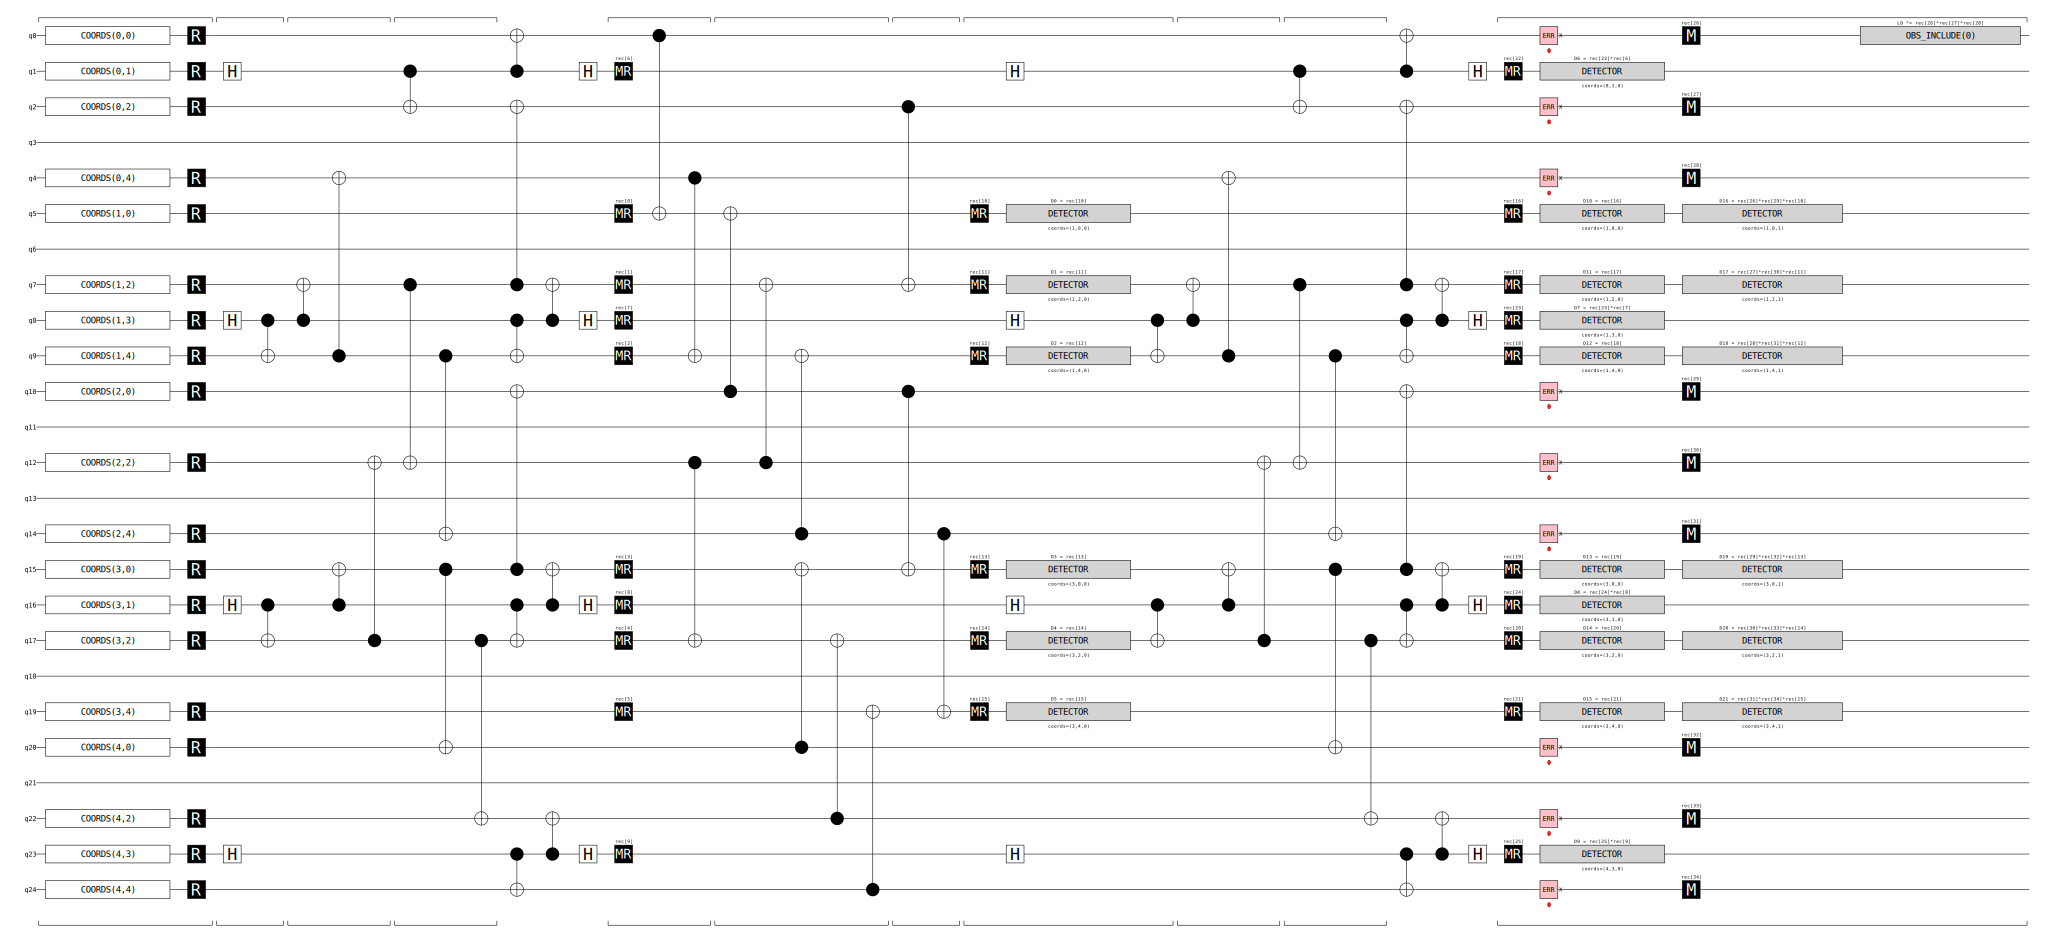

In [7]:
stim_hhc.diagram('timeline-svg')

In [7]:
dem=stim_hhc.detector_error_model(decompose_errors=True)

ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D5', 'D7', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D5:D7 > output_image.svg

This was discovered while analyzing a Z-basis reset (R) on:
    qubit 19 [coords (3, 4)]

The collapse anti-commuted with these detectors/observables:
    D5 [coords (1, 3, 0)]
    D7 [coords (4, 3, 0)]

The backward-propagating error sensitivity for D5 was:
    Z8 [coords (1, 3)]
    X12 [coords (2, 2)]
    X17 [coords (3, 2)]
    X19 [coords (3, 4)]
    X22 [coords (4, 2)]

The backward-propagating error sensitivity for D7 was:
    X12 [coords (2, 2)]
    X17 [coords (3, 2)]
    X19 [coords (3, 4)]
    X22 [coords (4, 2)]
    Z23 [coords (4, 3)]

Circuit stack trace:
    during TICK layer #1 of 17
    at instruction #20 [which is R 0 2 4 10 12 14 20 22 24 1 8 16 23 5 7 9 15 17 19]

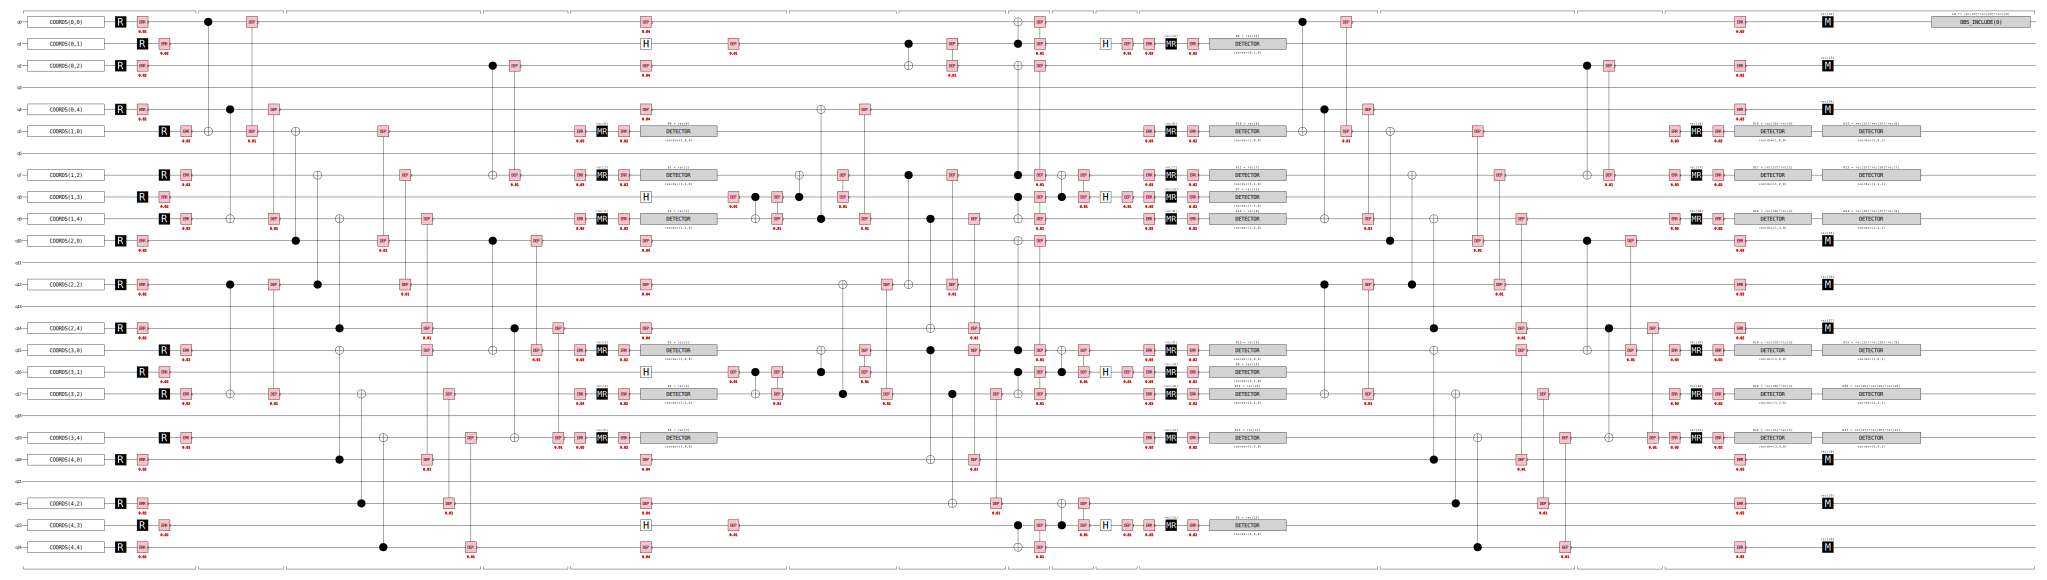

In [39]:
stim_hhc.diagram('timeline-svg')

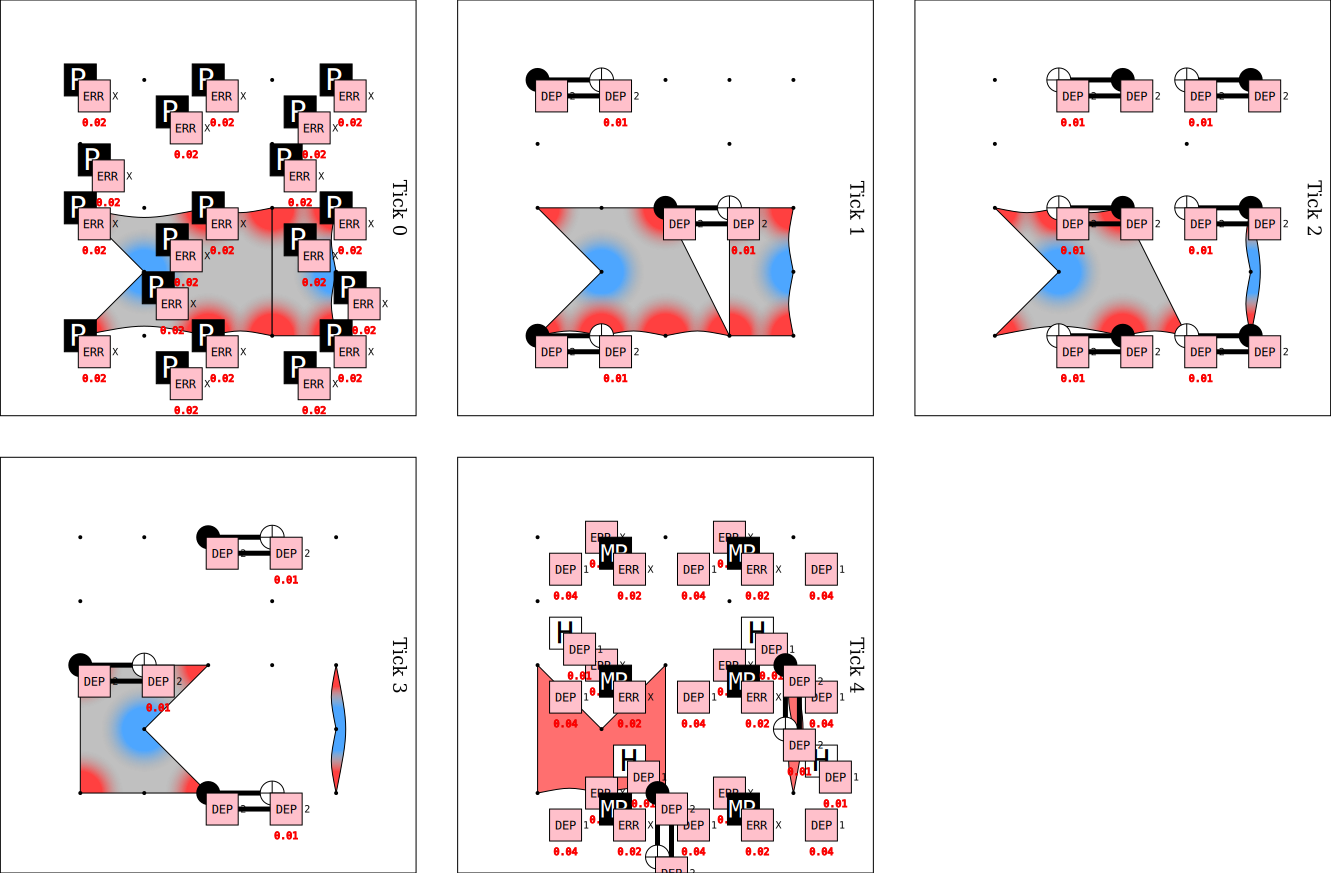

In [22]:
stim_hhc.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D7', 'D9', ])

In [9]:
print(stim_hhc.to_crumble_url())

https://algassert.com/crumble#circuit=Q(0,0)0;Q(0,2)2;Q(0,4)4;Q(0,6)6;Q(0,8)8;Q(2,0)18;Q(2,2)20;Q(2,4)22;Q(2,6)24;Q(2,8)26;Q(4,0)36;Q(4,2)38;Q(4,4)40;Q(4,6)42;Q(4,8)44;Q(6,0)54;Q(6,2)56;Q(6,4)58;Q(6,6)60;Q(6,8)62;Q(8,0)72;Q(8,2)74;Q(8,4)76;Q(8,6)78;Q(8,8)80;Q(0,1)1;Q(0,5)5;Q(1,3)12;Q(1,7)16;Q(3,1)28;Q(3,5)32;Q(5,3)48;Q(5,7)52;Q(7,1)64;Q(7,5)68;Q(8,3)75;Q(8,7)79;Q(1,0)9;Q(1,2)11;Q(1,4)13;Q(1,6)15;Q(1,8)17;Q(3,0)27;Q(3,2)29;Q(3,4)31;Q(3,6)33;Q(3,8)35;Q(5,0)45;Q(5,2)47;Q(5,4)49;Q(5,6)51;Q(5,8)53;Q(7,0)63;Q(7,2)65;Q(7,4)67;Q(7,6)69;Q(7,8)71;RX_0_2_4_6_8_18_20_22_24_26_36_38_40_42_44_54_56_58_60_62_72_74_76_78_80;Z_ERROR(0.02)0_2_4_6_8_18_20_22_24_26_36_38_40_42_44_54_56_58_60_62_72_74_76_78_80;R_1_5_12_16_28_32_48_52_64_68_75_79;X_ERROR(0.02)1_5_12_16_28_32_48_52_64_68_75_79;R_9_11_13_15_17_27_29_31_33_35_45_47_49_51_53_63_65_67_69_71;X_ERROR(0.02)9_11_13_15_17_27_29_31_33_35_45_47_49_51_53_63_65_67_69_71;TICK;H_1_5_12_16_28_32_48_52_64_68_75_79;DEPOLARIZE1(0.01)1_5_12_16_28_32_48_52_64_68

In [44]:
sampler=stim_hhc.compile_detector_sampler()

# detection_event=True means that the detector caught an error. False means that the detector did not catch an error.
# observable_flips=True means that the observable was flipped. False means that the observable was not flipped.
detection_events, observable_flips=sampler.sample(100, separate_observables=True)

In [39]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [40]:
num_shots = 10_000
num_logical_errors = count_logical_errors(stim_hhc, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")
print("Logical Error Rate:", (num_logical_errors / num_shots)*100, "%")

ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(5, 15), filter_coords=['D15', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 5:15 --filter_coords D15 > output_image.svg

This was discovered while analyzing a Z-basis demolition measurement (MR) on:
    qubit 23 [coords (4, 3)]

The collapse anti-commuted with these detectors/observables:
    D15 [coords (4, 3, 0)]

The backward-propagating error sensitivity for D15 was:
    X23 [coords (4, 3)]

Circuit stack trace:
    during TICK layer #11 of 21
    at instruction #59 [which is MR 5 7 9 15 17 19 1 8 16 23]

In [17]:
cc=stim.Circuit(
    """
    R 0 1 2
    H 0
    CX 0 1
    CX 2 1
    MR 0 1 2
    DETECTOR rec[-3]
    DETECTOR rec[-2]
    DETECTOR rec[-1]
    """
)

In [18]:
sampler=cc.compile_detector_sampler()
detection_events, observable_flips=sampler.sample(100, separate_observables=True)

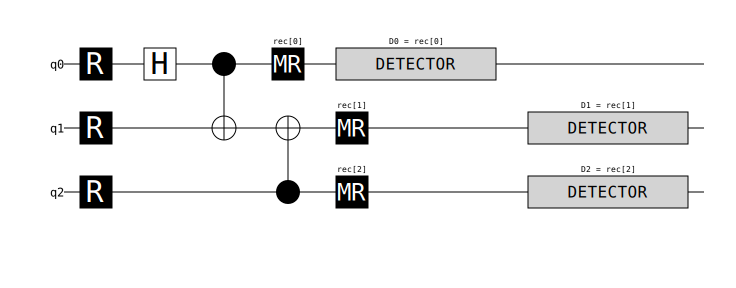

In [34]:
cc.diagram('timeline-svg')

In [33]:
detection_events[:, 2]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
cc1=stim.Circuit(
    """
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(0, 2) 2
    QUBIT_COORDS(0, 4) 4
    QUBIT_COORDS(2, 0) 10
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(2, 4) 14
    QUBIT_COORDS(4, 0) 20
    QUBIT_COORDS(4, 2) 22
    QUBIT_COORDS(4, 4) 24
    QUBIT_COORDS(0, 1) 1
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(3, 1) 16
    QUBIT_COORDS(4, 3) 23
    QUBIT_COORDS(1, 0) 5
    QUBIT_COORDS(1, 2) 7
    QUBIT_COORDS(1, 4) 9
    QUBIT_COORDS(3, 0) 15
    QUBIT_COORDS(3, 2) 17
    QUBIT_COORDS(3, 4) 19
    R 0 2 4 10 12 14 20 22 24 1 8 16 23 5 7 9 15 17 19
    TICK
    H 1 8 16 23
    CX 8 9 16 17
    TICK
    CX 8 7 9 4 16 15 17 12
    TICK
    CX 1 2 7 12 9 14 15 20 17 22
    TICK
    CX 1 0 7 2 8 9 15 10 16 17 23 24
    TICK
    CX 8 7 16 15 23 22
    TICK
    H 1 8 16 23
    TICK
    MR 5 7 9 15 17 19 1 8 16 23
    TICK
    H 1 8 16 23
    CX 8 9 16 17
    TICK
    CX 8 7 9 4 16 15 17 12
    TICK
    CX 1 2 7 12 9 14 15 20 17 22
    TICK
    CX 1 0 7 2 8 9 15 10 16 17 23 24
    TICK
    CX 8 7 16 15 23 22
    TICK
    H 1 8 16 23
    TICK
    MR 5 7 9 15 17 19 1 8 16 23
    DETECTOR rec[-1] rec[-11]
    DETECTOR rec[-2] rec[-12]
    DETECTOR rec[-3] rec[-13]
    DETECTOR rec[-4] rec[-14]
    DETECTOR rec[-5] rec[-15]
    DETECTOR rec[-6] rec[-16]
    DETECTOR rec[-7] rec[-17]
    DETECTOR rec[-8] rec[-18]
    DETECTOR rec[-9] rec[-19]
    DETECTOR rec[-10] rec[-20]
    """
    )

In [12]:
sampler=cc1.compile_detector_sampler()
detection_events, observable_flips=sampler.sample(100, separate_observables=True)

In [13]:
print(detection_events)

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False

In [19]:
cc2=stim.Circuit(
    """
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(0, 2) 2
    QUBIT_COORDS(0, 4) 4
    QUBIT_COORDS(2, 0) 10
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(2, 4) 14
    QUBIT_COORDS(4, 0) 20
    QUBIT_COORDS(4, 2) 22
    QUBIT_COORDS(4, 4) 24
    QUBIT_COORDS(0, 1) 1
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(3, 1) 16
    QUBIT_COORDS(4, 3) 23
    QUBIT_COORDS(1, 0) 5
    QUBIT_COORDS(1, 2) 7
    QUBIT_COORDS(1, 4) 9
    QUBIT_COORDS(3, 0) 15
    QUBIT_COORDS(3, 2) 17
    QUBIT_COORDS(3, 4) 19
    R 0 2 4 10 12 14 20 22 24 1 8 16 23 5 7 9 15 17 19
    TICK
    CX 0 5 4 9 12 17
    TICK
    CX 10 5 12 7 14 9 20 15 22 17 24 19
    TICK
    CX 2 7 10 15 14 19
    TICK
    MR 5 7 9 15 17 19
    DETECTOR(1, 0, 0) rec[-6]
    DETECTOR(1, 2, 0) rec[-5]
    DETECTOR(1, 4, 0) rec[-4]
    DETECTOR(3, 0, 0) rec[-3]
    DETECTOR(3, 2, 0) rec[-2]
    DETECTOR(3, 4, 0) rec[-1]
    """
)

sampler=cc2.compile_detector_sampler()
detection_events, observable_flips=sampler.sample(100, separate_observables=True)
print(detection_events)

[[False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False